# Imports




In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, random_split
from transformers import BertTokenizer, BertForMaskedLM, get_linear_schedule_with_warmup, DataCollatorForLanguageModeling
from torch.optim import AdamW
import matplotlib.pyplot as plt
from datasets import Dataset
from torch.cuda.amp import autocast, GradScaler

In [ ]:
# Settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16
num_epochs = 15
learning_rate = 5e-5
max_length = 64  # max token length

In [ ]:
emotion_df = pd.read_parquet("hf://datasets/dair-ai/emotion/unsplit/train-00000-of-00001.parquet")
emotion_dataset = Dataset.from_pandas(emotion_df) # switching to Dataset format

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Tokenize dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )

tokenized_dataset = emotion_dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/416809 [00:00<?, ? examples/s]

In [ ]:
# Train/Validation Split
train_size = int(0.8 * len(tokenized_dataset))
val_size = len(tokenized_dataset) - train_size
train_dataset, val_dataset = random_split(tokenized_dataset, [train_size, val_size])

In [ ]:
# Data Collator (handles masking)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
    num_workers=2
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
    num_workers=2
)

In [ ]:
# Model
model = BertForMaskedLM.from_pretrained("bert-base-uncased")
model.to(device)

# Freeze bottom layers
for param in model.bert.encoder.layer[:6].parameters():
    param.requires_grad = False

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = num_epochs * len(train_dataloader)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

scaler = GradScaler()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipython-input-1713779702.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


# Finding optimal epoch number for trainig

In [ ]:
# Training Loop
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    epoch_train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # masked labels

        # Correct autocast usage
        with torch.amp.autocast(device_type="cuda"):
          outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            with torch.amp.autocast(device_type="cuda"):
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                epoch_val_loss += outputs.loss.item()

    avg_val_loss = epoch_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

Epoch 1/15 - Train Loss: 2.400244, Val Loss: 2.215968
Epoch 2/15 - Train Loss: 2.257309, Val Loss: 2.155521
Epoch 3/15 - Train Loss: 2.212210, Val Loss: 2.128753
Epoch 4/15 - Train Loss: 2.182778, Val Loss: 2.122260
Epoch 5/15 - Train Loss: 2.136718, Val Loss: 2.089179
Epoch 6/15 - Train Loss: 2.109839, Val Loss: 2.075893
Epoch 7/15 - Train Loss: 2.084916, Val Loss: 2.054203
Epoch 8/15 - Train Loss: 2.062908, Val Loss: 2.050027
Epoch 9/15 - Train Loss: 2.049933, Val Loss: 2.039589
Epoch 10/15 - Train Loss: 2.033770, Val Loss: 2.027915
Epoch 11/15 - Train Loss: 2.021109, Val Loss: 2.029928
Epoch 12/15 - Train Loss: 2.009047, Val Loss: 2.025319
Epoch 13/15 - Train Loss: 2.000285, Val Loss: 2.007256
Epoch 14/15 - Train Loss: 1.990315, Val Loss: 1.991657
Epoch 15/15 - Train Loss: 1.987206, Val Loss: 2.002245


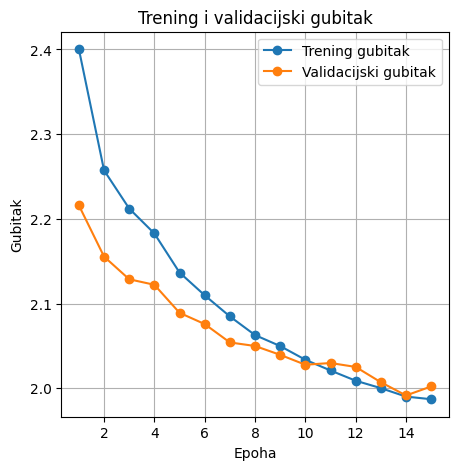

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(5,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Trening gubitak", marker="o")
plt.plot(range(1, len(train_losses)+1), val_losses, label="Validacijski gubitak", marker="o")
plt.xlabel("Epoha")
plt.ylabel("Gubitak")
plt.title("Trening i validacijski gubitak")
plt.legend()
plt.grid(True)
plt.show()

# Fine tuning model in optimal number of epochs - 14



In [ ]:
# Training Loop
train_losses, val_losses = [], []

for epoch in range(14):
    # --- Training ---
    model.train()
    epoch_train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # masked labels

        # Correct autocast usage
        with torch.amp.autocast(device_type="cuda"):
          outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

In [ ]:
# Saving model to google drive
from google.colab import drive

drive.mount('/content/drive')

drive_save_path = "/content/drive/MyDrive/modeli/fine_tuned_bert"
model.save_pretrained(drive_save_path)
tokenizer.save_pretrained(drive_save_path)

Mounted at /content/drive


('/content/drive/MyDrive/modeli/fine_tuned_bert_14/tokenizer_config.json',
 '/content/drive/MyDrive/modeli/fine_tuned_bert_14/special_tokens_map.json',
 '/content/drive/MyDrive/modeli/fine_tuned_bert_14/vocab.txt',
 '/content/drive/MyDrive/modeli/fine_tuned_bert_14/added_tokens.json')